# MediCluster — Modeling
**Goal:** Pick K, fit K-Means, visualize clusters (PCA 2D), baseline DBSCAN, and profile segments.

## Imports

In [89]:
# Core
import pandas as pd
import numpy as np

# Paths
from src.__00__paths import processed_data_dir, figures_dir, docs_dir, model_dir

# Model & Visualization
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import joblib

## Load Data

In [90]:
df = pd.read_csv(processed_data_dir / "processed_patients_dataset.csv")

## Finding the Best K through Elbow & Silhouette

Plot Saved → outputs/figures/kmeans_elbow.png


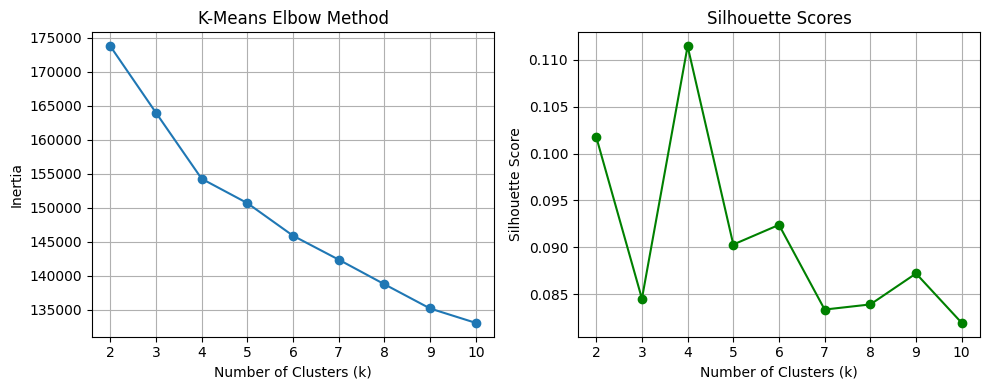

In [91]:
# 1. Find optimal k
inertia = []
silhouette_scores = []
K_range = range(2, 11)  # try k=2 to k=10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df, kmeans.labels_))

# Plot elbow method
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('K-Means Elbow Method')
plt.grid(True)

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.grid(True)

plt.tight_layout()
plt.savefig(figures_dir / "kmeans_elbow.png")
print(f"Plot Saved → {'/'.join((figures_dir / "kmeans_elbow.png").parts[-3:])}")
plt.show()

## Fit final K-Means with chosen k (example: k=4)

In [92]:
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans_final.fit_predict(df)

# Metrics
ch_score = calinski_harabasz_score(df, kmeans_final.labels_)
db_score = davies_bouldin_score(df, kmeans_final.labels_)

seeds = range(5)
labels_list = [KMeans(n_clusters=best_k, random_state=rs, n_init=10).fit(df).labels_ for rs in seeds]
stability = np.mean([
    adjusted_rand_score(labels_list[i], labels_list[j])
    for i in range(len(seeds)) for j in range(i + 1, len(seeds))
])

# Prepare clean output
output_lines = []
output_lines.append(f"Best k: {best_k}")
output_lines.append("Cluster counts:")
for cluster_id, count in df['cluster'].value_counts().sort_index().items():
    output_lines.append(f"{cluster_id}    {count}")
output_lines.append(f"Calinski–Harabasz: {ch_score:.2f}, Davies–Bouldin: {db_score:.2f}")
output_lines.append(f"KMeans stability (ARI): {stability:.3f}")

# Print
for line in output_lines:
    print(line)

# Save to txt
metrics_path = docs_dir / "kmeans_metrics.txt"
with open(metrics_path, "w") as f:
    f.write("\n".join(output_lines))

print(f"✔️ Metrics saved → {'/'.join(metrics_path.parts[-3:])}")

Best k: 4
Cluster counts:
0    1525
1    1467
2    1522
3    1486
Calinski–Harabasz: 602.07, Davies–Bouldin: 2.68
KMeans stability (ARI): 1.000
✔️ Metrics saved → outputs/docs/kmeans_metrics.txt


## Save Clustered Data

In [93]:
# Load pre-scaled clean data (original units)
df_original_units = pd.read_csv(processed_data_dir / "clean_preScaled_data.csv")

# Add the cluster column from your KMeans results
df_original_units['cluster'] = df['cluster']  # df is your scaled+weighted DataFrame with clusters

# Save it
df_original_units.to_csv(docs_dir / "clustered_patients_dataset_original_units.csv", index=False)
print(f"✔️ Saved → {'/'.join((docs_dir / 'clustered_patients_dataset_original_units.csv').parts[-3:])}")

✔️ Saved → outputs/docs/clustered_patients_dataset_original_units.csv


✔️ Figure saved  outputs/figures/kmeans_pca2d.png


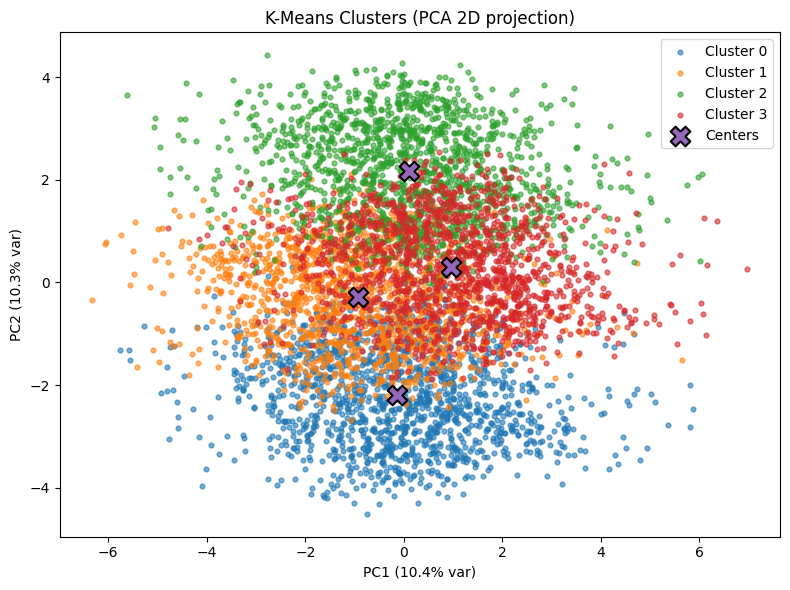

In [94]:
# Split features / labels
X = df.drop(columns=['cluster']).values
y = df['cluster'].values

# Fit PCA on the SAME feature space used for K-Means
pca_vis = PCA(n_components=2)
X_2d = pca_vis.fit_transform(X)

# Project K-Means centers to 2D using the same PCA
centers_2d = pca_vis.transform(kmeans_final.cluster_centers_)

# Build a scatter plot
plt.figure(figsize=(8, 6))
for c in np.unique(y):
    idx = (y == c)
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], s=12, alpha=0.6, label=f'Cluster {c}')

# Overlay cluster centers
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], s=200, marker='X', edgecolor='k', linewidth=1.5, label='Centers')

out_path = figures_dir / "kmeans_pca2d.png"

# Annotate axes with variance explained
var = pca_vis.explained_variance_ratio_ * 100
plt.xlabel(f'PC1 ({var[0]:.1f}% var)')
plt.ylabel(f'PC2 ({var[1]:.1f}% var)')
plt.title('K-Means Clusters (PCA 2D projection)')
plt.legend()
plt.tight_layout()
plt.savefig(out_path)
print(f"✔️ Figure saved  {'/'.join(out_path.parts[-3:])}")
plt.show()

## Save Model Pipeline

### Lightweight column weighter

In [95]:
class ColumnWeighter(BaseEstimator, TransformerMixin):
    def __init__(self, columns, weights: dict):
        self.columns = list(columns)
        self.weights = np.array([weights.get(c, 1.0) for c in self.columns], dtype=float)

    def fit(self, X, y=None):
        # optional sanity check
        if isinstance(X, pd.DataFrame):
            missing = [c for c in self.columns if c not in X.columns]
            if missing:
                raise ValueError(f"Weight columns not found: {missing}")
        return self

    def transform(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        return X * self.weights  # broadcast per column

### Columns & weights (must match training features)

In [96]:
feature_cols = [c for c in df.columns if c != "cluster"]  # df is your scaled+weighted training frame

weights = {
    # High importance
    "plasma_glucose": 1.8,
    "blood_pressure": 1.8,
    "cholesterol": 1.8,
    "bmi": 1.8,
    "hypertension": 1.8,
    "heart_disease": 1.8,
    # Medium importance
    "chest_pain_type": 1.3,
    "exercise_angina": 1.3,
    "max_heart_rate": 1.3,
    "insulin": 1.3,
}

### Category mapper (strings -> numeric) to mirror training encodings

In [97]:
def map_categories(X_df: pd.DataFrame) -> pd.DataFrame:
    X = X_df.copy()
    if "smoking_status" in X.columns:
        X["smoker"] = X["smoking_status"].map({"Smoker": 1, "Non-Smoker": -1, "Unknown": 0})
        X.drop(columns=["smoking_status"], inplace=True)
    if "gender" in X.columns and X["gender"].dtype == object:
        X["gender"] = X["gender"].map({"Female": 0, "Male": 1}).astype(int)
    if "residence_type" in X.columns and X["residence_type"].dtype == object:
        X["residence_type"] = X["residence_type"].map({"Urban": 0, "Rural": 1}).astype(int)
    # Ensure exact training column order (adds NaNs for missing cols -> will be scaled; should not be missing)
    return X.reindex(columns=feature_cols)

### Build pipeline: map → scale → weight → KMeans (initialized with learned centers)

In [98]:
pipe = Pipeline(steps=[
    ("map_categories", FunctionTransformer(map_categories, validate=False)),
    ("scale", StandardScaler()),
    ("weight", ColumnWeighter(feature_cols, weights)),
    ("kmeans", KMeans(
        n_clusters=int(best_k),
        random_state=42,
        n_init=1,  # use your learned centers once
        init=kmeans_final.cluster_centers_  # centers are in scaled+weighted space
    )),
])

### Fit pipeline on original-units data (strings allowed)

In [99]:
# Use the same original-units dataframe you saved earlier
df_fit_raw = df_original_units.copy()
pipe.fit(df_fit_raw)

bundle_path = model_dir / "medicluster_kmeans_pipeline.joblib"
joblib.dump({"pipeline": pipe, "feature_cols": feature_cols}, bundle_path)

print(f"✔️ Inference pipeline saved → {'/'.join(bundle_path.parts[-3:])}")

✔️ Inference pipeline saved → outputs/models/medicluster_kmeans_pipeline.joblib


In [100]:
new_patient_df = pd.DataFrame([{
    "age": 24, "gender": "Male", "chest_pain_type": 4, "blood_pressure": 250, "cholesterol": 139,
    "max_heart_rate": 212, "exercise_angina": 0, "plasma_glucose": 108, "skin_thickness": 33,
    "insulin": 109, "bmi": 38, "diabetes_pedigree": 0.48, "hypertension": 1, "heart_disease": 1,
    "residence_type": "Urban", "smoking_status": "Smoker"
}])
pred_cluster = pipe.predict(new_patient_df)[0]
print("Predicted cluster:", pred_cluster)

Predicted cluster: 2
